In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
from jupyterthemes import jtplot

In [3]:
jtplot.style('default', grid=False)

In [14]:
def import_xps_spectrum(filename):
    dfin = pd.read_table(filename, sep='\s', skiprows=39, header=None, decimal='.', encoding='ascii')
    dfin.columns = ["Energy [eV]", "counts"]
    # dfin['Energy [eV]'] = dfin['Energy [eV]'].map('{:.0f}'.format)

    dfin.set_index("Energy [eV]", inplace=True)
    return dfin

In [15]:
file_bg = f'../xps_spectra/2019_09_26_Au_mica/20190927_Au_mica.xy'
df_bg = import_xps_spectrum(filename=file_bg)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [17]:
file_fbi = '../xps_spectra/2019_09_27_FBI_Au_mica/20190927_FBI_Au_mica_overview.xy'
df_fbi = import_xps_spectrum(file_fbi)

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [53]:
def find_and_plot_peaks(df : pd.DataFrame, thres : float = 0.5, col : str = 'r'):
    leny = len(df.index)
    peaks = peakutils.indexes(df.counts.values, thres=thres)
    x_peaks = df.index[peaks]
    y_peaks = df.counts.values[peaks]
    plt.plot(x_peaks, y_peaks, col+'o', label='Peaks at thres = %.1f' %thres)
    return peaks

# Plot substrate and deposition spectra

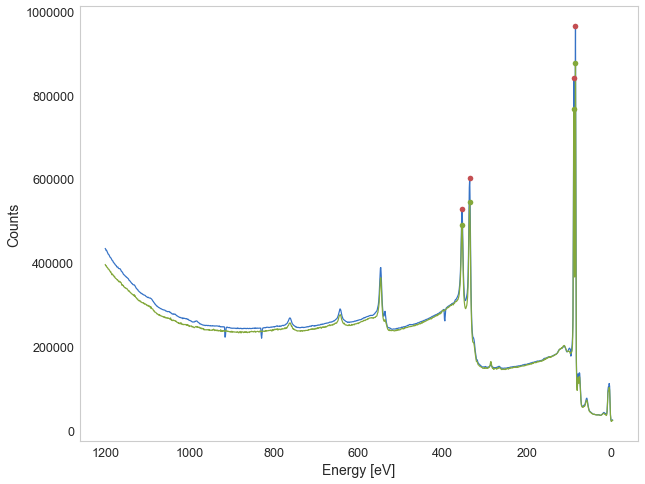

In [55]:
plt.figure(figsize=(10,8))
plt.plot(df_bg.counts, '-', label='Substrate spectrum: Au/Mica, sputtered and annealed')
plt.plot(df_fbi.counts, '-', label='FBI 2 pulses deposition 0.5 mM, 50 ms, 550 mbar')

plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('Counts', fontsize=14)
# plt.title()

pBg = find_and_plot_peaks(df_bg, thres=0.5)
pFbi = find_and_plot_peaks(df_fbi, thres=0.5, col='g')

plt.gca().invert_xaxis()
# plt.xlim(400,200)

## Compute normalization factor from Gold peaks

These may result from a slightly different position of the sample or the X-ray source

In [73]:
norm = df_bg.counts[pBg] / df_fbi.counts[pFbi]
normAv = np.average(norm)
normAv

1.0486905116582903

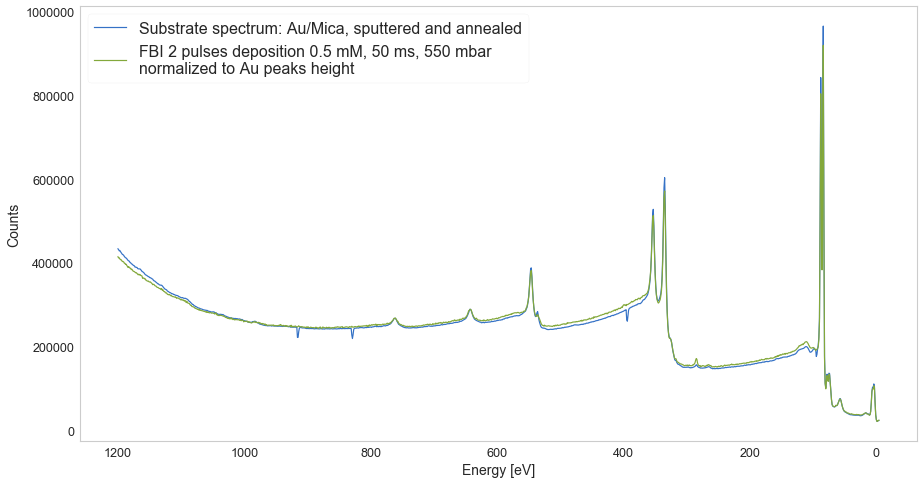

In [74]:
plt.figure(figsize=(15,8))
plt.plot(df_bg.counts, '-', label='Substrate spectrum: Au/Mica, sputtered and annealed')
plt.plot(df_fbi.counts*normAv, '-', label='FBI 2 pulses deposition 0.5 mM, 50 ms, 550 mbar \nnormalized to Au peaks height')

plt.xlabel('Energy [eV]', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.legend(fontsize = 16)
plt.gca().invert_xaxis()

# Compare elementwise number of counts

##  Import fine-resolved element spectra

In [88]:
pathBg = f'../xps_spectra/2019_09_26_Au_mica/20190927_Au_mica'
path500nM = f'../xps_spectra/2019_09_27_FBI_Au_mica/20190927_FBI_Au_mica'

Cbg = import_xps_spectrum(pathBg+'_C.xy')
Csg = import_xps_spectrum(path500nM+'_C.xy')

Nsg = import_xps_spectrum(path500nM+'_N.xy')
Nbg = import_xps_spectrum(pathBg+'_N.xy')

Obg = import_xps_spectrum(pathBg+'_O.xy')
Osg = import_xps_spectrum(path500nM+'_O.xy')

Ba_bg = import_xps_spectrum(pathBg+'_Ba.xy')
Ba_sg = import_xps_spectrum(path500nM+'_Ba.xy')

# Didn't record bg fine resolved Cl spectra
Cl_sg = import_xps_spectrum(path500nM+'_Cl.xy')

Csg.counts *= normAv
Nsg.counts *= normAv
Osg.counts *= normAv
Ba_sg.counts *= normAv
Cl_sg.counts *= normAv

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [121]:
Cl_sg.index.values
Cl_bg = df_bg.counts[Cl_sg.index.values].dropna()
Cl_bg = pd.DataFrame(Cl_bg)
# Cl_bg = pd.DataFrame('Energy [eV]' = Cl_sg.index)

## Plot individual element spectra

In [142]:
def plot_xps_element_spectra(df_bg : pd.DataFrame, df_sg : pd.DataFrame, ax, lb):
    ax.plot(df_bg.counts, '-', label=lb+'_Substrate')
    ax.plot(df_sg.counts, '-', label=lb+'_Deposition')

    ax.set_xlabel('Energy [eV]', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.legend(fontsize = 12)
    ax.invert_xaxis()

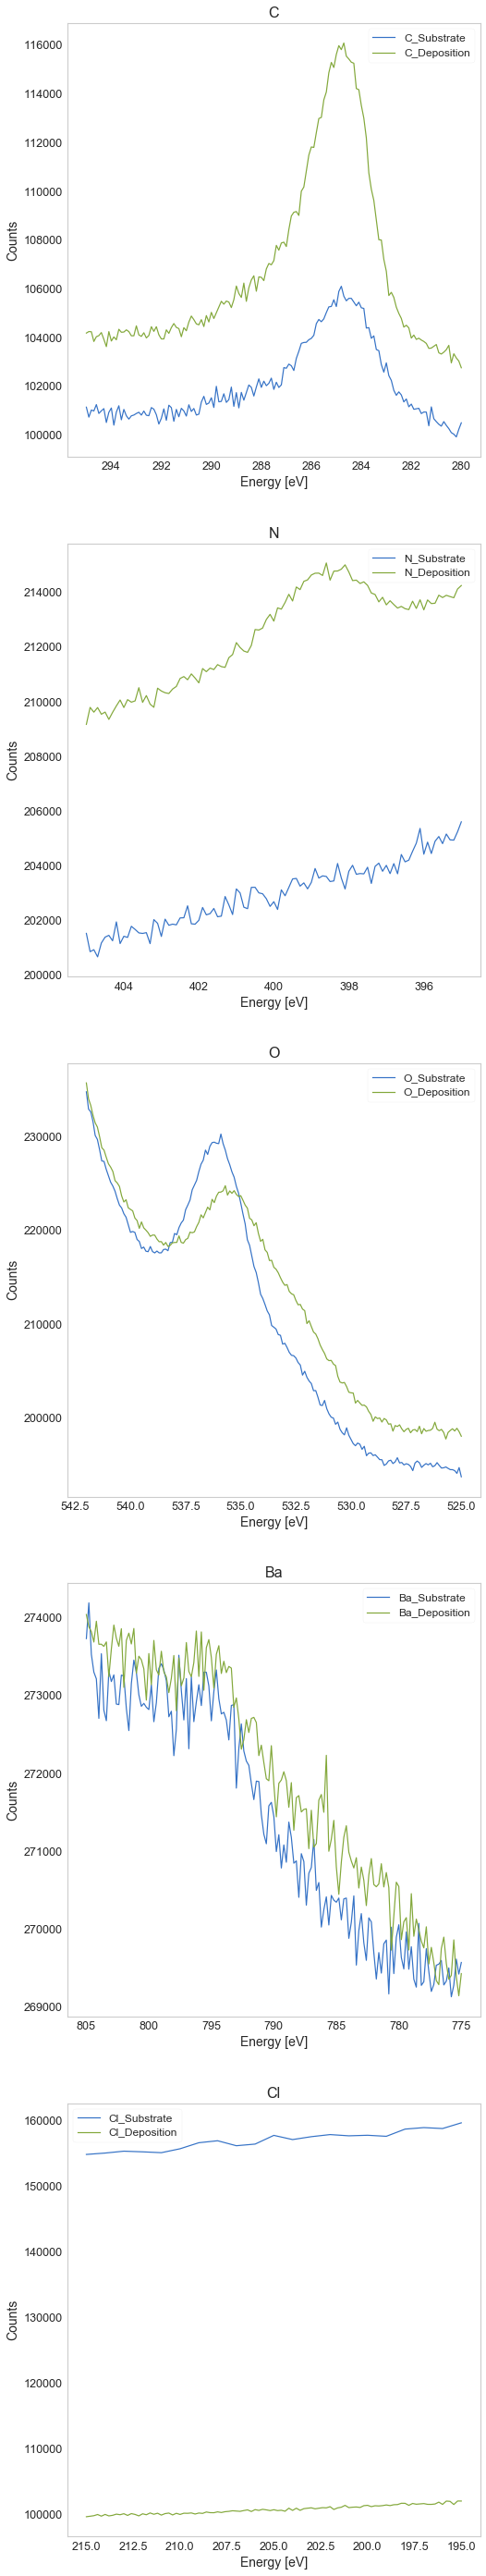

In [144]:
fig, ax = plt.subplots(5)
elem = ['C', 'N', 'O', 'Ba', 'Cl']
data_sg = [Csg, Nsg, Osg, Ba_sg, Cl_sg]
data_bg = [Cbg, Nbg, Obg, Ba_bg, Cl_bg]
for i, (d_sg, d_bg) in enumerate(zip(data_sg, data_bg)):
    plot_xps_element_spectra(d_bg, d_sg, ax[i], lb=elem[i])
    ax[i].set_title(elem[i], fontsize=16)
    
plt.gcf().set_figheight(10*len(ax))
plt.gcf().set_figwidth(8)

# Summary

#####  We have no clear signal of Ba nor Cl so the Barium perchlorate doesn't clearly survive

- We do have some clear excess in the C and N peaks, probably from the acetonitrile (CH_3CN) and there could be some contribution from molecule ($C_{31}H_{35}BaCl_2N_3O_{13})$ where there are 31 and 13 atoms per molecule of C and N, respectively.

- In the case of the O peak seems that the deposition covers part of the overlap with the tail of a gold core level

#####  In a 0.5 µM solution of FBI in 0.3 mL Acetonitrile there are some 11 molecules of solvent for each solute molecule

It is a very dissolved mix but the molecular weight of FBI is 21x larger than that of AcN


In [152]:
Na = 6.023e23
N_FBI = 0.5e-6 # per L
rho_AcN = 0.786 # g/mL
M_AcN = 41.05 # g/mol
N_AcN = 0.3e-3 * rho_AcN / M_AcN
N_AcN / N_FBI

11.4884287454324

In [153]:
M_FBI = 865.86 # g/mol
M_FBI / M_AcN

21.092813641900122

##### So the molecule is not so much outnumbered by solvent which, in any case, should have evaporated during the deposition

## Outlook
- We can try improving the barium signal by repeating the deposition increasing either
  - The number of pulses, say, to 100 this time
  - The solution concentration, say, to 100 µM
- I saw in [Rev](#Rev) section 3 there are tricks to quantify the concentration of the deposition, I could give it a shot but I'm not sure the statistics will allow it

<a id='Rev'></a>
Steffen Oswald, X-Ray Photoelectron Spectroscopy in Analysis of Surfaces

https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470027318.a2517.pub2

# Plot whole spectra plus element ranges 

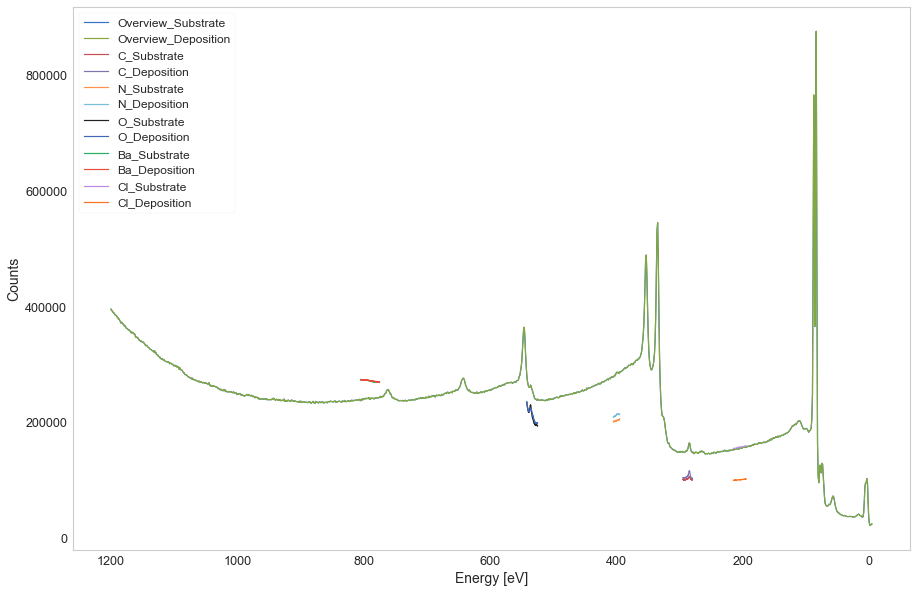

In [146]:
fig, ax = plt.subplots(1)
elem = ['Overview', 'C', 'N', 'O', 'Ba', 'Cl']
data_sg = [df_fbi, Csg, Nsg, Osg, Ba_sg, Cl_sg]
data_bg = [df_fbi, Cbg, Nbg, Obg, Ba_bg, Cl_bg]
for i, (d_sg, d_bg) in enumerate(zip(data_sg, data_bg)):
    plot_xps_element_spectra(d_bg, d_sg, ax, lb=elem[i])
#     ax.set_title(elem[i], fontsize=16)

ax.invert_xaxis()
    
plt.gcf().set_figheight(10)
plt.gcf().set_figwidth(15)